In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import *
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import geopy.distance
from obspy.taup import TauPyModel
import glob

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


In [2]:
file_list = glob.glob("/data/data5/Converted/whidbey_2022-05-17_08-07*")
file_list
#download oso earthquake data
chan_min = 1400
chan_max = 1500


data_file = h5py.File('/data/data5/Converted/whidbey_2022-05-17_08-07-00_UTC_014622.h5','r')

this_data = np.array(data_file['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
this_time = np.array(data_file['Acquisition/Raw[0]/RawDataTime'])
attrs =     dict(data_file['Acquisition'].attrs)
            
data_file.close()
low_cut1 = 1
hi_cut1 = 10
fs = 100

b,a = butter(2,(low_cut1,hi_cut1),'bp',fs=fs)
data_filt = filtfilt(b,a,this_data,axis=0)

template = data_filt[5000:5500,:]
template.shape
data_filt.shape



def correlate(s1,s2,mode="same"):

    # throw an error of input sizes are inconsistent
    if s1.shape != s2.shape:
        raise ValueError("s1 and s2 must have the same size!")

    # get fft size
    sz = s1.shape[0]
    n_bits = 1+int(np.log2(2*sz-1))
    fft_sz = 2**n_bits

    # take FFT along time axis for both
    fft_s1 = np.fft.fft(s1, fft_sz, axis=0)
    fft_s2 = np.fft.fft(s2, fft_sz, axis=0)

    # take complex conjugate of second signal
    fft_s2_conj = np.conj(fft_s2)

    # multiply to get correlation function
    corr_fft = fft_s1*fft_s2_conj

    # take inverse fourier transform
    corr = np.fft.ifft(corr_fft, axis=0)

    # normalize using the magnitude of both input data
    norm1 = np.linalg.norm(s1,axis=0)
    norm2 = np.linalg.norm(s2,axis=0)
    norm_factor = norm1*norm2
    corr = np.vstack((corr[-(sz-1) :], corr[:sz]))
    norm_corr = np.real(corr) / norm_factor

    # return desired part of correlation function
    if mode == "full":
        pass
    elif mode == "same":
        norm_corr = norm_corr[int(sz/2):-int(sz/2)+1]
    return norm_corr


def window_and_correlate(template,data):

    # define container
    all_corr = []

    # get some helpful values
    window_length = template.shape[0]
    num_windows = int(data.shape[0]/window_length)

    # iterate through time windows
    for i in range(num_windows):

        # pull out a time window of data
        start_index = i*window_length
        end_index = start_index + window_length
        window = data[start_index:end_index,:]

        # call cross correlation function
        corr = correlate(template,window)

        # save value
        all_corr.append(corr)

    # reshape output
    all_corr = np.stack(all_corr)

    return all_corr
corrs =  []
corrs = (window_and_correlate(template,data_filt))

Text(0.5, 0, 'windows_time')

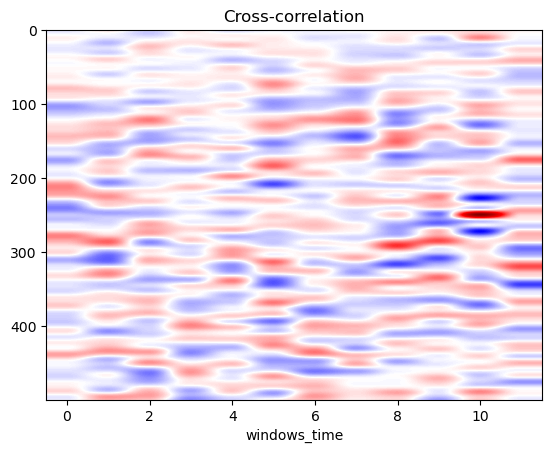

In [15]:

# list
correlation_to_plot = corrs[0]

plt.imshow(corrs[:, :, 10].T, cmap='seismic', aspect='auto', vmin=-1.0, vmax=1.0)
# Cross-correlation-plot

plt.title('Cross-correlation')
plt.xlabel("windows_time")


In [6]:
corrs.shape

(12, 500, 100)

In [4]:
len(corrs)

12

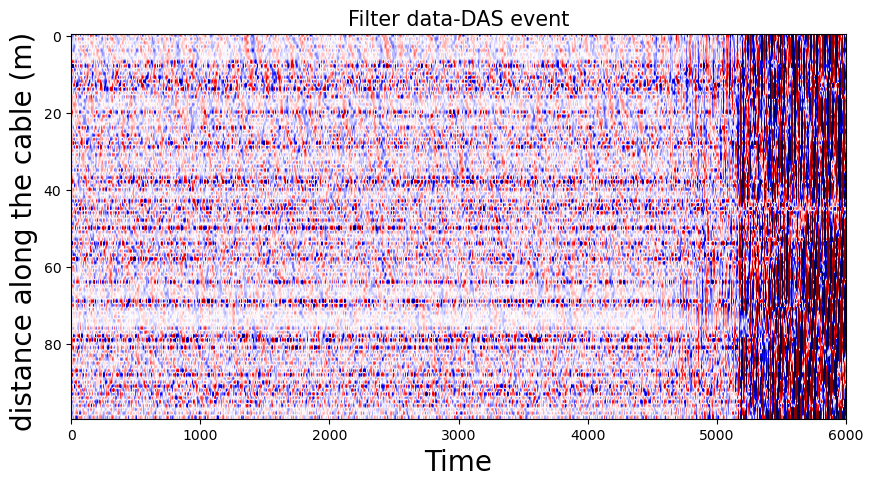

In [5]:
fig,ax=plt.subplots(figsize=(10,5))
plt.imshow(data_filt.T,cmap='seismic',aspect='auto',vmin=-0.5,vmax=0.5)#,extent=[x_lims[0],x_lims[-1],x_max,0])
plt.title('Filter data-DAS event', fontsize=15)
plt.xlabel("Time", fontsize=20)
plt.ylabel("distance along the cable (m) ", fontsize=20)


plt.show()
